In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

plt.rcParams.update({
    "font.size": 14
}) 

In [97]:
def calculate_cv(theta_2, theta_3):
    sigma_h_sq = theta_3 ** 2 / (1 - theta_2 ** 2)
    return np.exp(sigma_h_sq) - 1

def plot_cv_theta_two(df_qml, df_smm, title, x_bounds=None, y_bounds=None):
    _, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(data=df_qml, x="cv", y="estimates_2", ax=ax, label="QML");
    sns.scatterplot(data=df_smm, x="cv", y="estimates_2", ax=ax, label="SMM");
    ax.set_xlabel("CV")
    ax.set_ylabel("theta_2")
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)

def plot_qml_vs_smm_estimates(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))

    for i in range(3):
        qml_col = f"estimates_{i+1}_qml"
        smm_col = f"estimates_{i+1}_smm"
        min_value = min(df[qml_col].min(), df[smm_col].min())
        max_vallue = max(df[qml_col].max(), df[smm_col].max())
        y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
        sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax[i], label="y=x", color="red", linestyle="--")
        sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax[i]);
    fig.suptitle(title)
    plt.tight_layout()


def plot_qml_vs_smm_cv(df, title,  x_bounds=None, y_bounds=None):
    fig, ax = plt.subplots(figsize=(7, 7))

    qml_col = "cv_qml"
    smm_col = "cv_smm"
    min_value = min(df[qml_col].min(), df[smm_col].min())
    max_vallue = max(df[qml_col].max(), df[smm_col].max())
    y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
    sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax, label="y=x", color="red", linestyle="--")
    sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax);
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)
    

In [98]:
def calculate_volatility_cv_sq(log_returns):
    mean_second_power = np.mean(np.power(log_returns, 2))
    mean_fourth_power = np.mean(np.power(log_returns, 4))
    return mean_fourth_power / (3 * mean_second_power**2) - 1

def plot_one_ticker(data, ticker):
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.lineplot(data=data.loc[data.ticker == ticker, :], x="date", y="log_return", ax=ax)
    ax.set_title(ticker);

In [115]:
ts_data = pd.read_csv("data/Data_no_outliers.csv")
ts_data["date"] = pd.to_datetime(ts_data.date, format="%Y%m%d")

vol_cv = (
    ts_data[["ticker", "log_return"]]
    .groupby(by="ticker")
    .agg(calculate_volatility_cv_sq)
    .rename(columns={"log_return": "vol_cv_squared"})
    .reset_index()
)

qml_with_outliers = pd.read_csv("qml_estimates_with_outliers.csv")
smm_with_outliers = pd.read_csv("smm_estimates_with_outliers.csv")

qml_without_outliers = pd.read_csv("qml_estimates_without_outliers.csv")
smm_without_outliers = pd.read_csv("smm_estimates_without_outliers.csv")

data_length = pd.read_csv('data/merged_data.csv')
data_length =  data_length.groupby(by='ticker').count()['date'].tolist()


dfs = [qml_with_outliers, qml_without_outliers, smm_with_outliers, smm_without_outliers]

for idx, df in enumerate(dfs):
    df  = pd.merge(left=df, right=vol_cv, on="ticker", how="left")
    df["cv"] = calculate_cv(df.estimates_2, df.estimates_3)
    df['size'] = data_length
    dfs[idx] = df

qml_with_outliers, qml_without_outliers = dfs[0], dfs[1]
smm_with_outliers, smm_without_outliers = dfs[2], dfs[3]

smm_with_outliers['name'] = 'smm_with_outliers'
smm_without_outliers['name'] = 'smm_without_outliers'
qml_without_outliers['name'] = 'qml_without_outliers'
qml_with_outliers['name'] = 'qml_with_outliers'


with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))

for df in [with_outliers, without_outliers]:
    df.rename(columns={"vol_cv_squared_smm": "cv_moments", "size_smm": "size"}, inplace=True)
    df.drop(columns=["vol_cv_squared_qml", "size_qml"], inplace=True)


### Первый вариант

In [4]:
def get_winner(theta_2, cv, size):
    is_short = size < 1000
    is_long = 1 - is_short

    is_cv_big = cv > 10
    is_cv_med = (1 - is_cv_big) * (cv > 1)
    is_cv_small = 1 - is_cv_big - is_cv_med

    is_theta_small = theta_2 < 0.9
    is_theta_med = (1 - is_theta_small) * (theta_2 < 0.95)
    is_theta_big = 1 - is_theta_small - is_theta_med

    wins_qml = np.zeros_like(size)
    wins_qml += is_long * is_cv_big
    wins_qml += is_long * is_theta_big * is_cv_med
    wins_qml += (size >= 2000) * is_theta_big * is_cv_small
    wins_qml += is_short * (size > 500) * is_theta_small * is_cv_big
    wins_qml = wins_qml > 0

    wins_smm = np.zeros_like(size)
    wins_smm += (size < 2000) * is_cv_small
    wins_smm += (size > 2000) * (size < 4000) * is_cv_small * is_theta_med
    wins_smm += is_cv_med * (1 - is_theta_big)
    wins_smm += is_short * is_theta_big * is_cv_med
    wins_smm = wins_smm > 0

    is_draw = 1 - wins_qml - wins_smm > 0

    smm_literal = pd.Series(["SMM" if flag else "" for flag in wins_smm])
    qml_literal = pd.Series(["QML" if flag else "" for flag in wins_qml])
    draw_literal = pd.Series(["?" if flag else "" for flag in is_draw])
    return smm_literal + qml_literal + draw_literal


def determine_winner(winner_qml, winner_smm):
    is_draw_qml = winner_qml == "?"
    is_draw_smm = winner_smm == "?"

    is_winner =  (winner_smm == winner_qml) * (1 - is_draw_qml) * (1 - is_draw_smm)
    return np.where(is_winner, winner_qml, pd.Series(["?" for _ in range(len(winner_qml))]))



In [5]:
for df in dfs:
    df.drop(index=np.where(df["size"] < 1000)[0], inplace=True)
    df.set_index('ticker', inplace = True)
    df["winner"] = get_winner(df["estimates_2"], df["cv"], df["size"]).to_list()



with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))

In [12]:
pd.Series(determine_winner(without_outliers.winner_qml, without_outliers.winner_smm)).value_counts()


SMM    21
?      20
Name: count, dtype: int64

In [13]:
without_outliers["winner"] = determine_winner(without_outliers.winner_qml, without_outliers.winner_smm)
without_outliers

,estimates_1_qml,estimates_2_qml,estimates_3_qml,cv_qml,size_qml,name_qml,winner_qml,estimates_1_smm,estimates_2_smm,estimates_3_smm,cv_smm,size_smm,name_smm,winner_smm,winner
ticker,,,,,,,,,,,,,,,
AFKS,-0.848200,0.897031,0.388591,1.166354,2323,qml_without_outliers,SMM,-0.813689,0.901284,0.470587,2.254055,2323,smm_without_outliers,SMM,SMM
AFLT,-0.677685,0.918708,0.407844,1.904984,2323,qml_without_outliers,SMM,-0.807593,0.903855,0.509211,3.122934,2323,smm_without_outliers,SMM,SMM
AGRO,-0.577343,0.932188,0.431502,3.141461,2298,qml_without_outliers,SMM,-0.916565,0.892177,0.544191,3.269719,2298,smm_without_outliers,SMM,SMM
ALRS,-0.346496,0.958155,0.213216,0.741615,2323,qml_without_outliers,QML,-0.812531,0.901828,0.416201,1.528908,2323,smm_without_outliers,SMM,?
BSPB,-0.655392,0.924218,0.416618,2.288093,2321,qml_without_outliers,SMM,-1.172861,0.864563,0.642326,4.123254,2321,smm_without_outliers,SMM,SMM
CBOM,-0.173194,0.982202,0.204142,2.258565,2203,qml_without_outliers,QML,-0.759176,0.921572,0.455197,2.954672,2203,smm_without_outliers,SMM,?
CHMF,-0.239182,0.971257,0.137365,0.395178,2323,qml_without_outliers,QML,-0.939088,0.889566,0.480987,2.030319,2323,smm_without_outliers,SMM,?
ENPG,-1.118254,0.859984,0.543504,2.108926,1031,qml_without_outliers,SMM,-0.965947,0.879787,0.576755,3.358148,1031,smm_without_outliers,SMM,SMM
FEES,-0.370991,0.955771,0.330027,2.522398,2309,qml_without_outliers,QML,-0.522026,0.938173,0.446529,4.279961,2309,smm_without_outliers,SMM,?


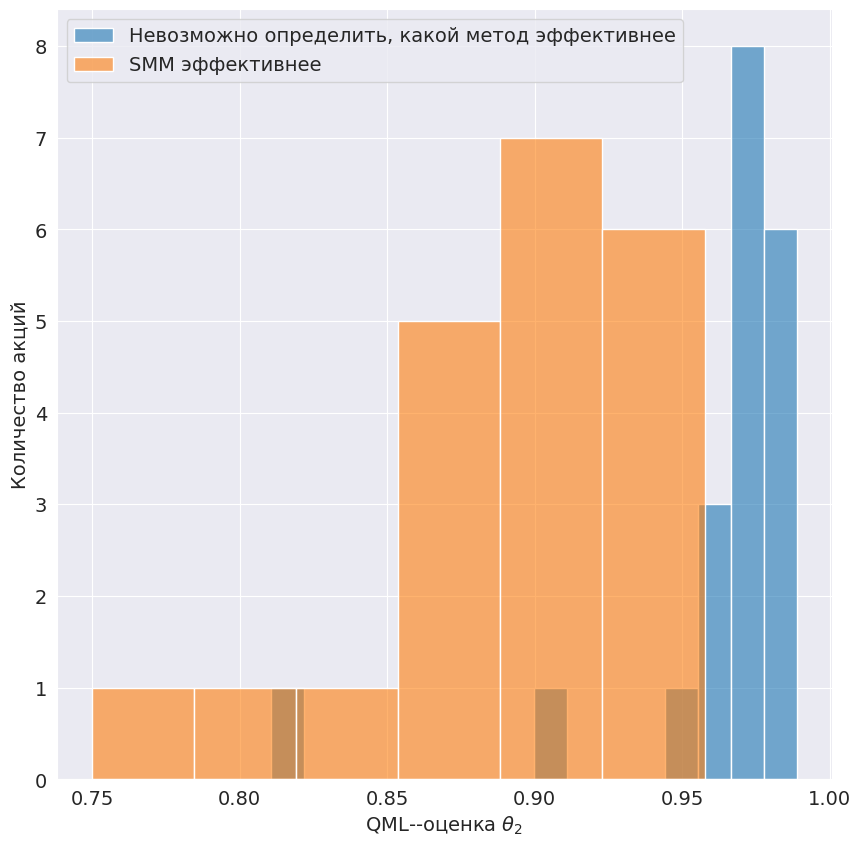

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=with_outliers[without_outliers.winner == "?"], x="estimates_2_qml", stat="count", label="Невозможно определить, какой метод эффективнее", alpha=0.6)
sns.histplot(data=with_outliers[without_outliers.winner == "SMM"], x="estimates_2_qml", stat="count", label="SMM эффективнее", alpha=0.6)

ax.set_xlabel(r'QML--оценка $\theta_2$')
ax.set_ylabel(r'Количество акций')

ax.legend()
plt.savefig("data/plots/theta_two_estimates.pdf", format="pdf");

### Второй вариант

План
1) Мы взяли такие то данные, почистили их и оценили модель... (берем все данные или только $T > 1000$)
2) фыва

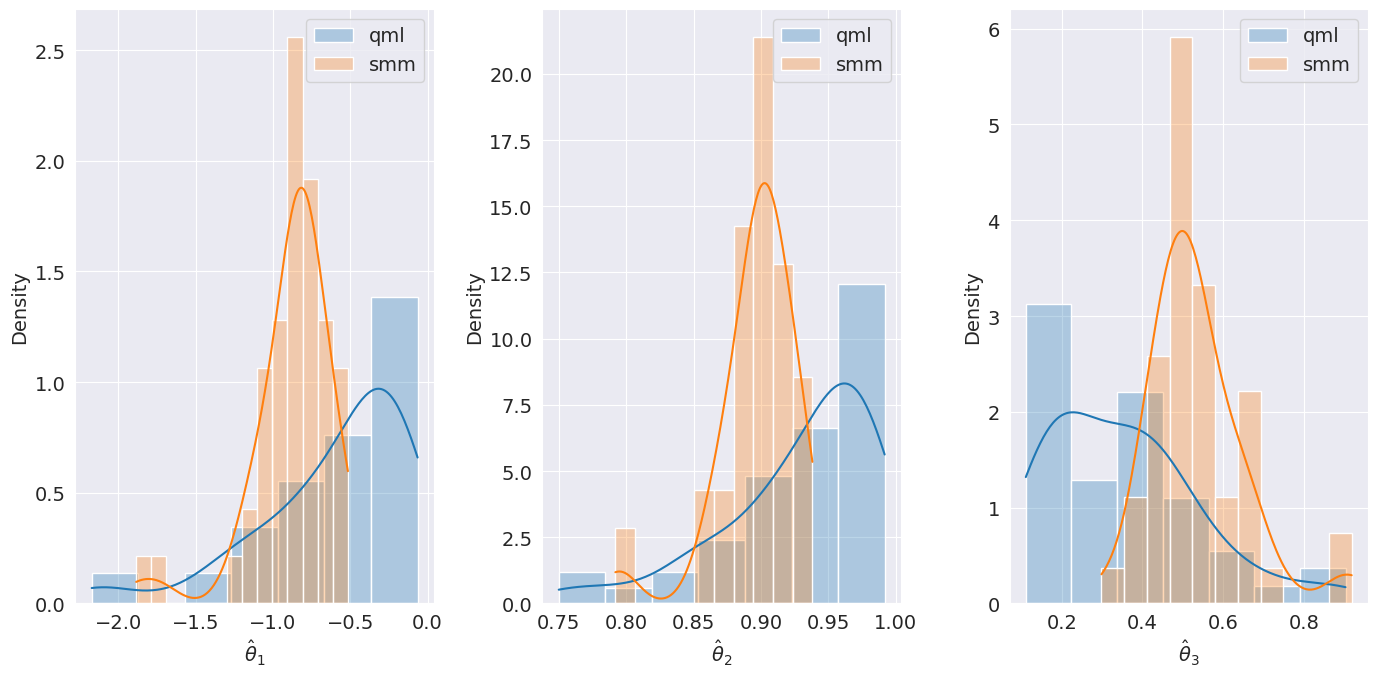

In [176]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 7))
stat = "estimates"
for param_idx in range(1, 4):
    for name in ["qml", "smm"]:
        sns.histplot(data=without_outliers, x=f"{stat}_{param_idx}_{name}", label=name, ax=ax[param_idx - 1], alpha=0.3, kde=True, stat="density")

for axis, label in zip(ax, [r"$\hat{\theta}_1$", r"$\hat{\theta}_2$", r"$\hat{\theta}_3$"]):        
    axis.set_xlabel(label)
    axis.legend()

plt.tight_layout();

In [165]:
without_outliers.sort_values(by="estimates_2_qml")

,ticker,estimates_1_qml,estimates_2_qml,estimates_3_qml,cv_qml,name_qml,estimates_1_smm,estimates_2_smm,estimates_3_smm,cv_moments,cv_smm,size,name_smm
47,VTBR,-2.171370,0.750003,0.826452,3.764600,qml_without_outliers,-0.822757,0.904342,0.489252,3.974851,2.721071,2323,smm_without_outliers
32,RTKM,-2.055715,0.777887,0.903676,6.908881,qml_without_outliers,-0.802262,0.912888,0.482571,2.761154,3.045114,2323,smm_without_outliers
24,NLMK,-1.558844,0.810625,0.449874,0.804425,qml_without_outliers,-0.881996,0.893534,0.412587,2.684800,1.326576,2323,smm_without_outliers
20,MSNG,-1.339243,0.843537,0.584838,2.273266,qml_without_outliers,-1.095966,0.872943,0.612876,2.930904,3.847304,2321,smm_without_outliers
22,MTLRP,-1.233387,0.844810,0.698815,4.505388,qml_without_outliers,-0.930606,0.883895,0.639014,4.657073,5.467944,2321,smm_without_outliers
37,SGZH,-1.180086,0.858842,0.508477,1.678770,qml_without_outliers,-1.723728,0.797903,0.896562,9.436645,8.136305,732,smm_without_outliers
7,ENPG,-1.118254,0.859984,0.543504,2.108926,qml_without_outliers,-0.965947,0.879787,0.576755,5.168364,3.358148,1031,smm_without_outliers
40,SNGSP,-1.224593,0.861491,0.565486,2.456423,qml_without_outliers,-1.883802,0.791992,0.918993,9.970593,8.638133,2323,smm_without_outliers
28,PIKK,-1.040310,0.881931,0.676026,6.820692,qml_without_outliers,-0.688936,0.921867,0.519304,4.497641,5.024901,2323,smm_without_outliers
44,TRNFP,-0.951592,0.890246,0.541557,3.111028,qml_without_outliers,-1.255652,0.854454,0.615353,3.624978,3.067061,2319,smm_without_outliers


In [152]:
without_outliers.describe()

,estimates_1_qml,estimates_2_qml,estimates_3_qml,cv_qml,estimates_1_smm,estimates_2_smm,estimates_3_smm,cv_moments,cv_smm,size
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,-0.602763,0.928970,0.353301,2.075288,-0.876628,0.896779,0.534641,4.813073,4.074595,2027.395833
std,0.490964,0.056537,0.186213,1.553074,0.260679,0.029112,0.117444,1.815885,3.030342,580.661719
min,-2.171370,0.750003,0.110899,0.395178,-1.883802,0.791992,0.298578,1.555201,0.781057,567.000000
25%,-0.825391,0.903130,0.201352,1.021314,-0.945803,0.885712,0.471285,3.608182,2.327214,2289.000000
50%,-0.426836,0.945869,0.335194,1.518029,-0.823363,0.901696,0.517866,4.484792,3.090061,2323.000000
75%,-0.243075,0.971590,0.450971,2.472917,-0.755455,0.914531,0.578775,5.676881,4.555495,2323.000000
max,-0.064780,0.991758,0.903676,6.908881,-0.515289,0.938173,0.918993,9.970593,16.300206,2323.000000


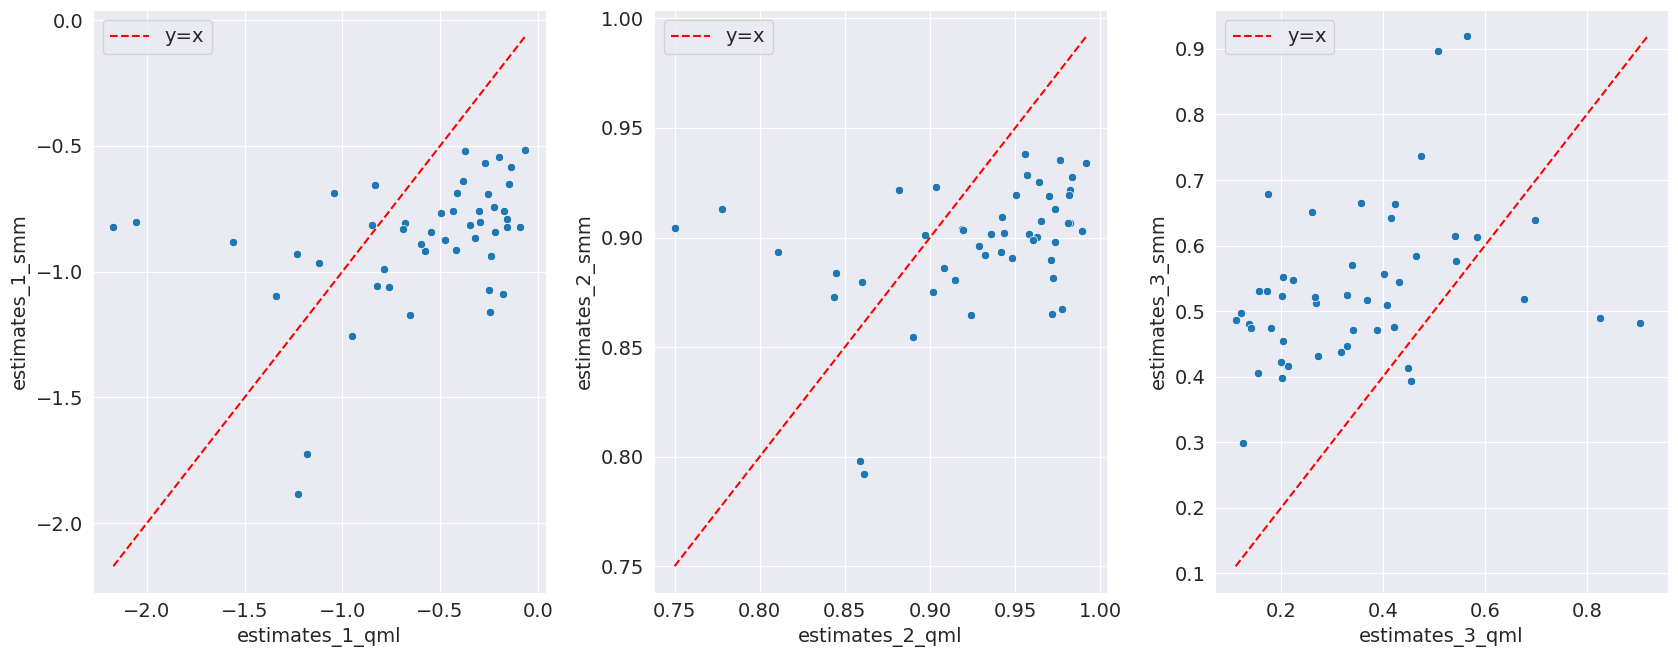

In [148]:
plot_qml_vs_smm_estimates(without_outliers, "")

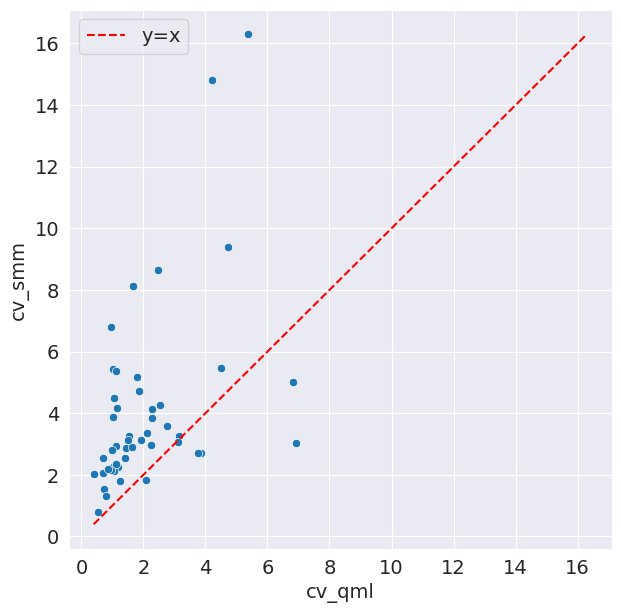

In [149]:
plot_qml_vs_smm_cv(without_outliers, "")

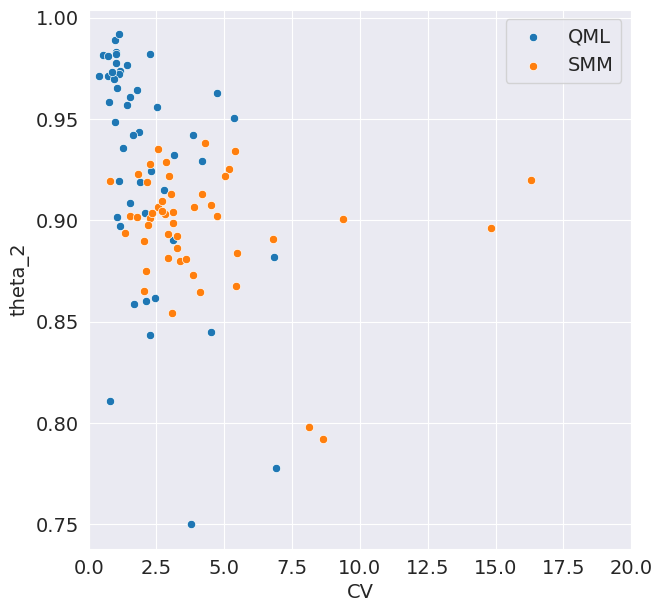

In [150]:
plot_cv_theta_two(qml_without_outliers, smm_without_outliers, "", x_bounds=(0, 20))

In [117]:
without_outliers.sort_values(by="cv_smm", ascending=False)

,ticker,estimates_1_qml,estimates_2_qml,estimates_3_qml,cv_qml,name_qml,estimates_1_smm,estimates_2_smm,estimates_3_smm,cv_moments,cv_smm,size,name_smm
38,SMLT,-0.415190,0.950416,0.423191,5.371684,qml_without_outliers,-0.685224,0.919620,0.663222,6.094180,16.300206,856,smm_without_outliers
36,SELG,-0.596615,0.928968,0.475149,4.195038,qml_without_outliers,-0.890083,0.896288,0.736974,5.156224,14.826299,2319,smm_without_outliers
10,FLOT,-0.323229,0.962922,0.356318,4.722595,qml_without_outliers,-0.865734,0.900408,0.665461,4.768463,9.378857,872,smm_without_outliers
40,SNGSP,-1.224593,0.861491,0.565486,2.456423,qml_without_outliers,-1.883802,0.791992,0.918993,9.970593,8.638133,2323,smm_without_outliers
37,SGZH,-1.180086,0.858842,0.508477,1.678770,qml_without_outliers,-1.723728,0.797903,0.896562,9.436645,8.136305,732,smm_without_outliers
30,POSI,-0.418080,0.948325,0.260554,0.962653,qml_without_outliers,-0.912615,0.890801,0.651124,7.532003,6.793965,567,smm_without_outliers
22,MTLRP,-1.233387,0.844810,0.698815,4.505388,qml_without_outliers,-0.930606,0.883895,0.639014,4.657073,5.467944,2321,smm_without_outliers
12,GLTR,-0.178893,0.977803,0.174731,1.004625,qml_without_outliers,-1.088493,0.867416,0.678614,3.046135,5.423693,856,smm_without_outliers
46,VKCO,-0.064780,0.991758,0.110899,1.115243,qml_without_outliers,-0.515289,0.934055,0.486105,5.114897,5.377155,917,smm_without_outliers
26,OZON,-0.271268,0.964169,0.268607,1.787620,qml_without_outliers,-0.569031,0.925339,0.511877,5.401817,5.188892,838,smm_without_outliers


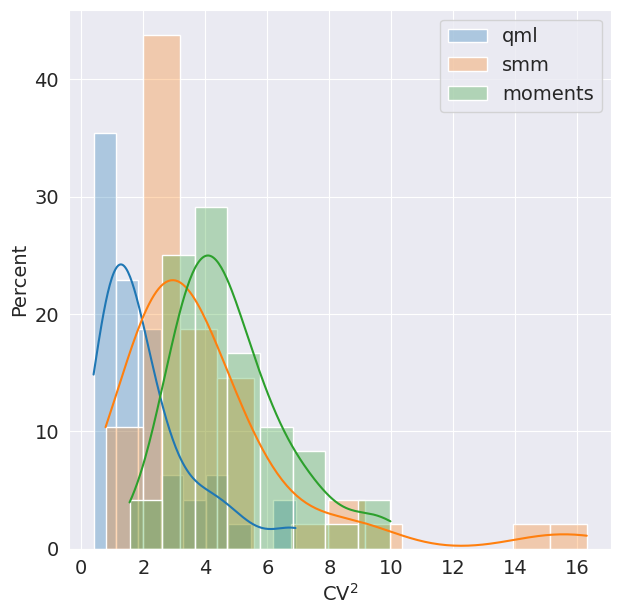

In [146]:
fig, ax = plt.subplots(figsize=(7, 7))
for name in ["qml", "smm", "moments"]:
    sns.histplot(data=without_outliers, x=f"cv_{name}", label=name, ax=ax, alpha=0.3, kde=True, stat="percent")
ax.set_xlabel(r"$\text{CV}^2$")
ax.legend();

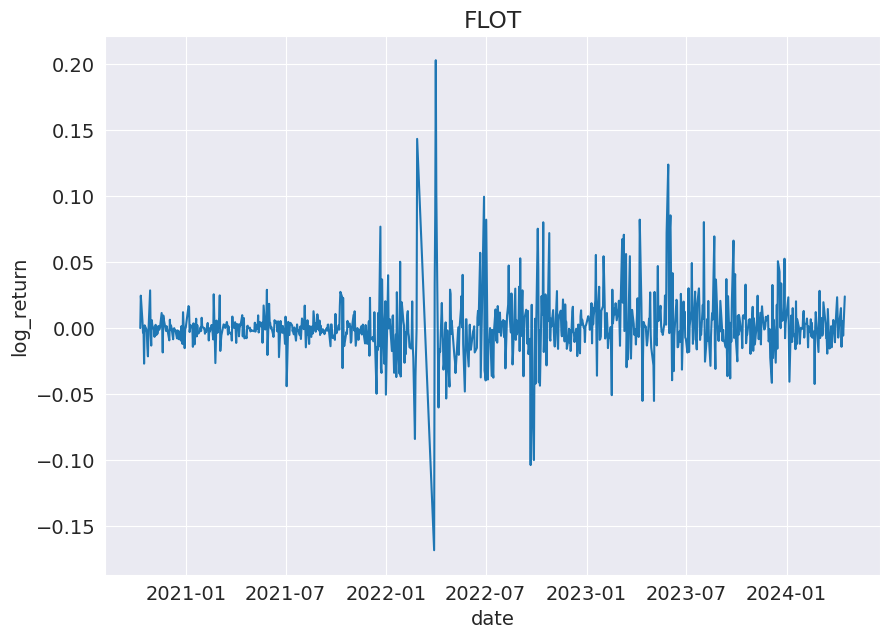

In [63]:
plot_one_ticker(ts_data, "FLOT")

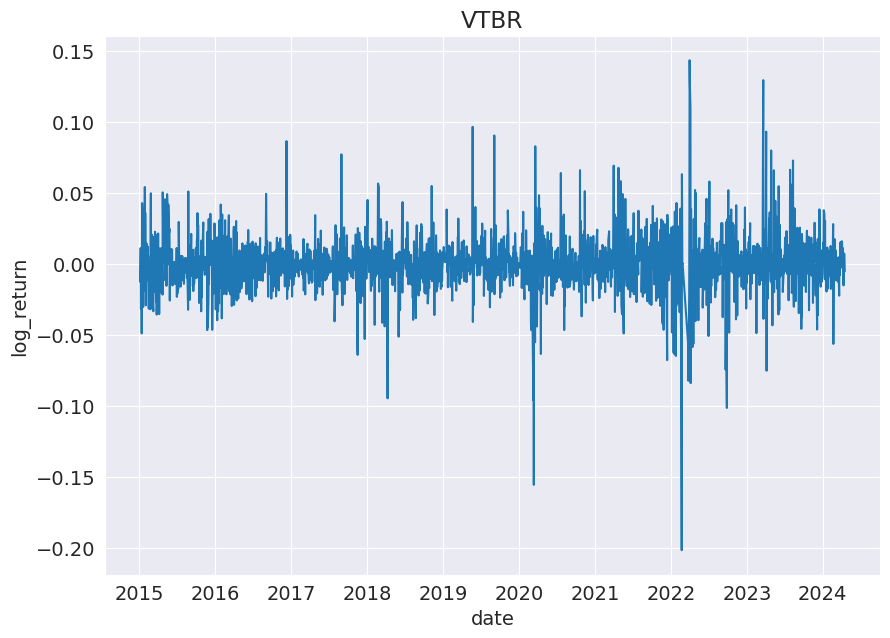

In [166]:
plot_one_ticker(ts_data, "VTBR")

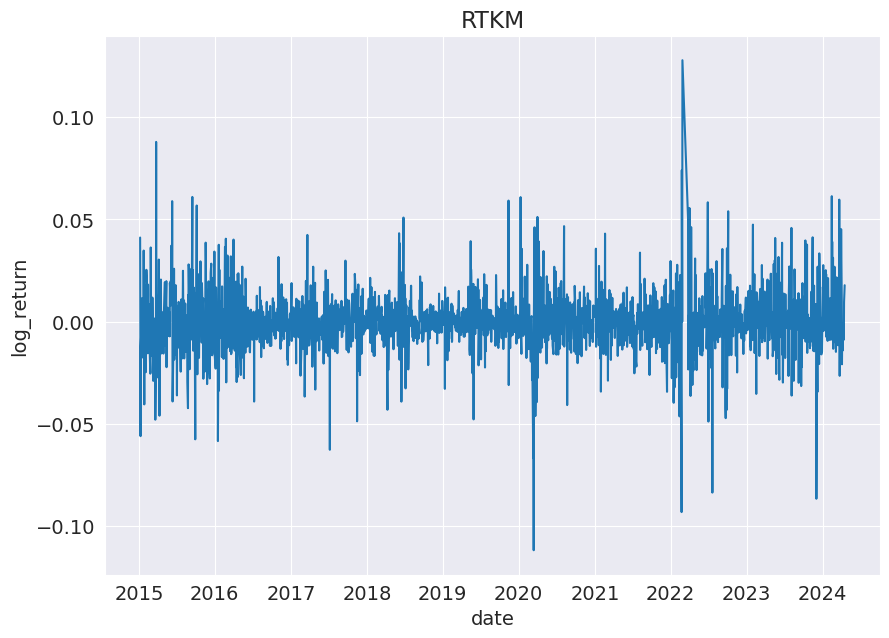

In [167]:
plot_one_ticker(ts_data, "RTKM")

In [147]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
# sns.heatmap(
#     without_outliers[[f"estimates_{i}_qml" for i in range(1, 4)]].corr(),
#     cmap="crest",
#     ax=ax[0]
# )
# ax[0].set_title("QML estimates corr")

# sns.heatmap(
#     without_outliers[[f"estimates_{i}_smm" for i in range(1, 4)]].corr(),
#     cmap="crest",
#     ax=ax[1]
# )
# ax[1].set_title("SMM estimates corr")


# plt.tight_layout()